<a href="https://colab.research.google.com/github/Danika-Balas/msds-462/blob/master/Transfer_Learning_with_Cats_and_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Introduction

In this notebook I demonstrate the power of transfer learning using the classic Kaggle dataset Dogs vs Cats. to create a classifier that distinguishes between images of cats and dogs. 

I started by developing a classifier that distinguishes between cats and dogs by using a convolutional neural network that I trained "from scratch" on this dataset.

Then I used transfer learning by applying the VGG16 model, which was pre-trained on the ImageNet dataset, to this dataset. I froze all of the layers in the VGG16 model except for the final three layers, which were trained on the Dogs vs Cats dataset.

Transfer learning is powerful because it harnesses the low-level features learned by models that are trained on massive datasets using vast computing resources. These are basic features such as edges, curves, and patterns that also compose images beyond the original training data. We can then create custom models by retraining the models on novel data. The custom models retain the low-level features while learning new high-level features that are specific to the novel data.

Models that were pre-trained on ImageNet work well for the Dogs vs Cats dataset because the content of the images in each dataset are similar. If we wanted to develop a model using transfer learning for a dataset that had very different images from ImageNet, we would need to retrain more of the layers within the model.

**Acknowledgements**

Code was adapted from the following sources:

Deep Learning with Python by Francis Chollet

Kaggle challenge: 
https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data

Reference kernels:
https://www.kaggle.com/jeffd23/catdognet-keras-convnet-starter
https://www.kaggle.com/gpreda/cats-or-dogs-using-cnn-with-transfer-learning


##Set up and prepackaging

In [66]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
sns.set(style="whitegrid")

from sklearn import metrics
from keras import metrics
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras import layers, models, optimizers
from keras import backend as K
from sklearn.model_selection import train_test_split

from tqdm import tqdm #progress bar
import os, cv2, random
from random import shuffle 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D

In [67]:
#TensorFlow version control
#%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

2.3.0


In [3]:
# #Upload files from local system
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

### Upload data

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# #unzip test files (smaller dataset to make sure it works)
# !unzip -uq "/content/drive/My Drive/MSDS Class Archive/422/cdtrain/test.zip" -d "/content/drive/My Drive/MSDS Class Archive/422/cdtrain/unzipped/"

In [69]:
#Check whether test files are readable
test_names = os.listdir('/content/drive/My Drive/MSDS Class Archive/422/cdtrain/unzipped/test')
print('# of files in testing directory', len(test_names))
print(test_names[:10])

# of files in testing directory 12500
['11475.jpg', '11496.jpg', '11519.jpg', '11539.jpg', '11559.jpg', '11532.jpg', '11561.jpg', '11554.jpg', '11518.jpg', '11563.jpg']


In [10]:
# #unzip training files
# !unzip -uq "/content/drive/My Drive/MSDS Class Archive/422/cdtrain/train.zip" -d "/content/drive/My Drive/MSDS Class Archive/422/cdtrain/unzipped/"

In [70]:
#Check whether training files are readable
train_names = os.listdir('/content/drive/My Drive/MSDS Class Archive/422/cdtrain/unzipped/train')
print('# of files in testing directory', len(train_names))
print(train_names[:10])

# of files in testing directory 25000
['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg', 'cat.10000.jpg', 'cat.10001.jpg', 'cat.10002.jpg', 'cat.10003.jpg', 'cat.10004.jpg']


### Pre-processing

In [71]:
#Set Parameters
TEST_SIZE = 0.2
RANDOM_STATE = 42
BATCH_SIZE = 64
EPOCHS = 20
NUM_CLASSES = 2
HALF_SAMPLE_SIZE = 3500 #Set to 1000 for training purposes, and to run fully through while producing PDF
PATH = '/content/drive/My Drive/MSDS Class Archive/422/cdtrain/unzipped/'
TRAIN_FOLDER = PATH+'train/'
TEST_FOLDER =  PATH+'test/'
IMG_SIZE = 224


##### Pull names from datasets, slice in order to split cats and dogs evenly


In [72]:
#Full datasets

train_images_full = [i for i in os.listdir(TRAIN_FOLDER)] # use this for full dataset

test_images_full =  [i for i in os.listdir(TEST_FOLDER)]

In [73]:
# Sliced datasets for memory efficiency while training
train_dogs =   [i for i in os.listdir(TRAIN_FOLDER) if 'dog' in i]
train_cats =   [i for i in os.listdir(TRAIN_FOLDER) if 'cat' in i]

train_images_sample = train_dogs[:HALF_SAMPLE_SIZE] + train_cats[:HALF_SAMPLE_SIZE]
random.shuffle(train_images_sample)
test_images_sample =  test_images_full[:100]

**Set datasets here:**




In [74]:
train_image_list = train_images_sample
test_image_list = test_images_sample

In [75]:
#One hot encoder
def label_pet_image_one_hot_encoder(img):
    pet = img.split('.')[-3]
    if pet == 'cat': return [1,0]
    elif pet == 'dog': return [0,1]

In [76]:
#to process data
def process_data(data_image_list, DATA_FOLDER, isTrain=True):
    data_df = []
    for img in tqdm(data_image_list):
        path = os.path.join(DATA_FOLDER,img)
        if(isTrain):
            label = label_pet_image_one_hot_encoder(img)
        else:
            label = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        data_df.append([np.array(img),np.array(label)])
    shuffle(data_df)
    return data_df

In [77]:
#Process training data
train = process_data(train_image_list, TRAIN_FOLDER)

100%|██████████| 7000/7000 [00:42<00:00, 165.64it/s]


In [78]:
#Process testing data
test = process_data(test_image_list, TEST_FOLDER, False)

100%|██████████| 100/100 [00:00<00:00, 163.71it/s]


In [79]:
train[1][1]

array([0, 1])

In [80]:
test[1][1]

array('11625', dtype='<U5')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Cats and Dogs')

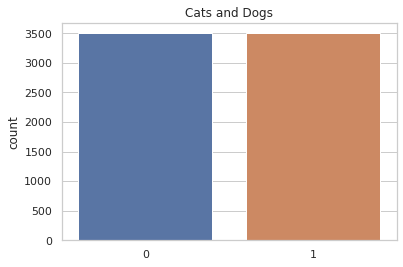

In [81]:
#Check that the data is balanced
labels = []
for i in train_image_list:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

sns.countplot(labels)
plt.title('Cats and Dogs')

### Sample of images

In [ ]:
#Display sample of images

def show_images(data, isTest=False):
    f, ax = plt.subplots(5,5, figsize=(15,15))
    for i,data in enumerate(data[:25]):
        img_num = data[1]
        img_data = data[0]
        label = np.argmax(img_num)
        if label  == 1: 
            str_label='Dog'
        elif label == 0: 
            str_label='Cat'
        if(isTest):
            str_label="None"
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
    plt.show()

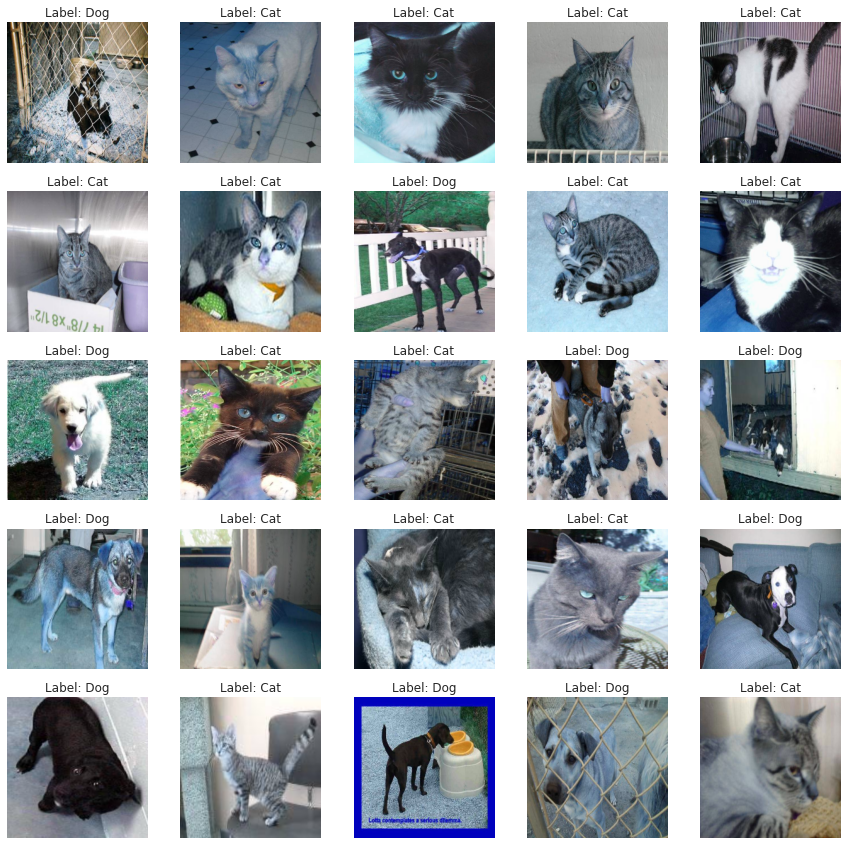

In [ ]:
#subset of training images
show_images(train)

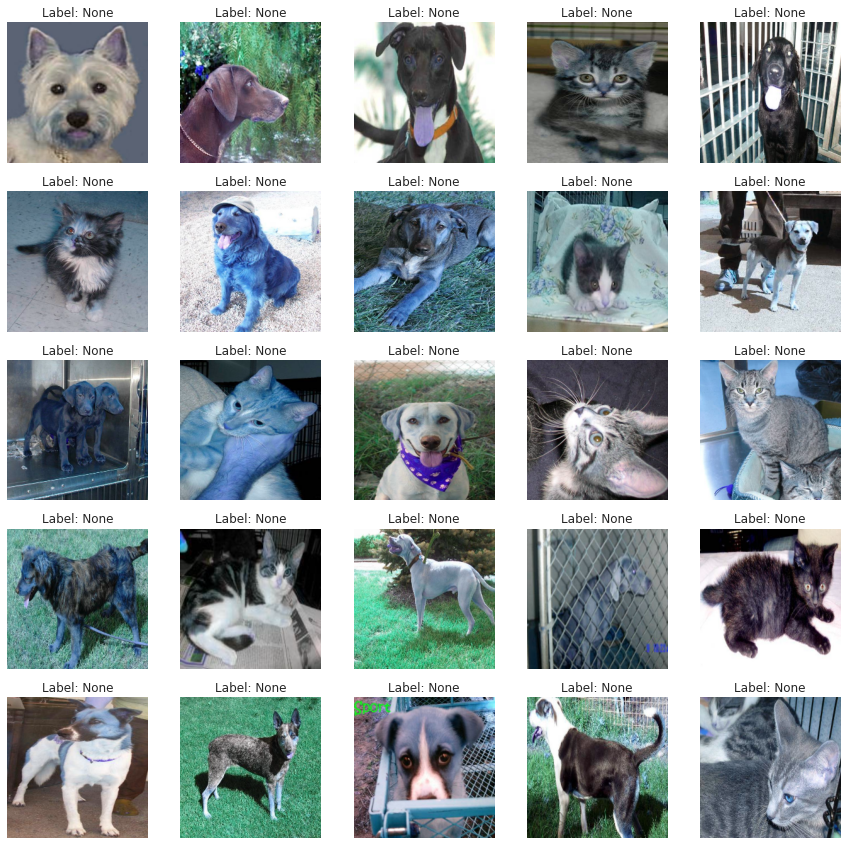

In [ ]:
#subset of test images
show_images(test, True)

### Arrays

In [82]:
#Change training data into arrays and reshape
X_all = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y_all = np.array([i[1][1] for i in train])

In [83]:
X_all.shape

(7000, 224, 224, 3)

In [84]:
y_all.shape

(7000,)

In [85]:
#Process final testing data
final_test_images_X = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
final_test_labels_y = np.array([i[1] for i in test])

In [86]:
#final_test_labels_y.astype(np.int)

In [87]:
final_test_images_X.shape

(100, 224, 224, 3)

In [88]:
final_test_labels_y.shape

(100,)

In [89]:
#Split the training data (80/20) for validation
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## Train Models

### CNN Model from Scratch

#### Initialize Model

In [90]:
BATCH_SIZE = 32
EPOCHS = 10

In [91]:
#Establish model parameters
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (3, 3))) 
model.add(layers.Activation('relu'))  
model.add(layers.MaxPooling2D(pool_size=(2, 2)))  

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten()) 
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

#Compile model
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
activation_12 (Activation)   (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_13 (Activation)   (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 52, 52, 32)       

#### Create image generator in order to augment data

In [92]:
#Image generator, inspired by Cole Thompson
data_aug = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    rotation_range=15, # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range =0.15, # Randomly zoom image 
    width_shift_range=0.1, # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1, # randomly shift images vertically (fraction of total height)
    horizontal_flip=True, # randomly flip images
    vertical_flip=False) # randomly flip images


In [93]:
#Prepare image generator for training dataset
train_generator = data_aug.flow(np.array(X_train), y_train, batch_size=BATCH_SIZE)

In [94]:
#Prepare validation generator
val_datagen = ImageDataGenerator(
    rescale=1. / 255)

val_generator = val_datagen.flow(np.array(X_val), y_val, batch_size=BATCH_SIZE)

In [95]:
len(X_train)/BATCH_SIZE

175.0

#### Train Model 1: 5 hidden layers

In [96]:
#Fit model 1
%%time

history = model.fit(
    train_generator, 
    steps_per_epoch=len(X_train) / BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=len(X_val) / BATCH_SIZE
)

Epoch 1/10
175/175 [==============================] - 57s 328ms/step - loss: 0.6925 - accuracy: 0.5495 - val_loss: 0.6623 - val_accuracy: 0.5836
Epoch 2/10
175/175 [==============================] - 58s 330ms/step - loss: 0.6462 - accuracy: 0.6346 - val_loss: 0.5977 - val_accuracy: 0.6771
Epoch 3/10
175/175 [==============================] - 57s 324ms/step - loss: 0.6138 - accuracy: 0.6668 - val_loss: 0.5768 - val_accuracy: 0.6957
Epoch 4/10
175/175 [==============================] - 57s 324ms/step - loss: 0.5849 - accuracy: 0.6900 - val_loss: 0.5404 - val_accuracy: 0.7336
Epoch 5/10
175/175 [==============================] - 57s 326ms/step - loss: 0.5545 - accuracy: 0.7136 - val_loss: 0.5568 - val_accuracy: 0.7143
Epoch 6/10
175/175 [==============================] - 57s 329ms/step - loss: 0.5391 - accuracy: 0.7423 - val_loss: 0.4898 - val_accuracy: 0.7686
Epoch 7/10
175/175 [==============================] - 57s 325ms/step - loss: 0.5254 - accuracy: 0.7429 - val_loss: 0.4999 - val_ac

#### Evaluate Model

In [97]:
final_loss, final_acc = model.evaluate(X_train, y_train, verbose=0)
print("Training loss: {0:.6f}, training accuracy: {1:.6f}".format(final_loss, final_acc))

Training loss: 59.620335, training accuracy: 0.715000


In [98]:
final_loss, final_acc = model.evaluate(X_val, y_val, verbose=0)
print("Testing loss: {0:.6f}, testing accuracy: {1:.6f}".format(final_loss, final_acc))

Testing loss: 67.394524, testing accuracy: 0.700000


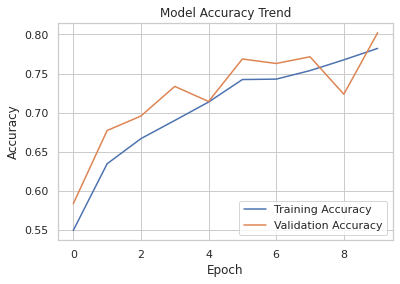

In [99]:
#Plot training and validation accuracy against epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy Trend")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training Accuracy", "Validation Accuracy"], loc="lower right")
plt.show()

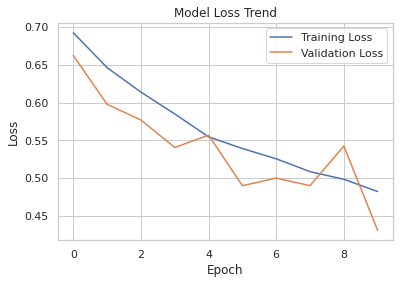

In [100]:
#Plot training and validation loss against epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss Trend")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Training Loss", "Validation Loss"], loc="upper right")
plt.show()

These results aren't terrible, but they could certainly be better. The model hasn't quite overfit, but allowing the model to train longer likely wouldn't improve these results by a lot. 

Some ways that we could improve the model are by increasing the amount of training data or improving our data augmentation. However, both of these steps would require significantly more computing resources in order to enable the model to learn the features better.

A convenient alternative is to use transfer learning, which should improve our results even with the same constraints on computing resources.

#### Prepare Prediction Submission

These are the steps we take if we want to submit our predictions to Kaggle.

In [ ]:
#Prediction with submission set
%%time
y_prediction = model.predict(final_test_images_X)
y_prediction.shape

CPU times: user 8min 13s, sys: 3.86 s, total: 8min 17s
Wall time: 19.2 s


In [ ]:
type(y_prediction)

numpy.ndarray

In [ ]:
prediction_unsorted = pd.DataFrame(zip(final_test_labels_y,y_prediction),columns=['id','label'])
prediction_unsorted.head()

,id,label
0,1888,[1.0]
1,7347,[1.0]
2,298,[1.0]
3,9201,[0.0]
4,10739,[1.0]


In [ ]:
cols = ['label']
for col in cols:
    prediction_unsorted[col] = prediction_unsorted[col].map(lambda x: str(x).lstrip('[').rstrip(']')).astype(float)
prediction_unsorted.head()

,id,label
0,1888,1.0
1,7347,1.0
2,298,1.0
3,9201,0.0
4,10739,1.0


In [ ]:
filename = 'prediction_1f.csv'
prediction_unsorted.to_csv(filename, index=False)

### Pre-Trained VGG16 Model

#### Initialize VGG16 model

In [109]:
from keras.applications import VGG16
conv_base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = (IMG_SIZE, IMG_SIZE, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                1605696   
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 16,320,449
Trainable params: 16,320,449
Non-trainable params: 0
_________________________________________________________________


#### Select which layers to freeze during training

In [110]:
# Freeze all but the last three convolutional layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [111]:
# # Freeze all layers in the base model
# for layer in conv_base.layers:
#   layer.trainable = False

In [112]:
model.compile(loss='binary_crossentropy', 
                   optimizer='rmsprop',  
                   metrics=['accuracy'])

#### Train Pre-Trained Model

In [113]:
#Fit model 
%%time

history = model.fit(
    train_generator, 
    steps_per_epoch=len(X_train) / BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=len(X_val) / BATCH_SIZE
)

Epoch 1/10
175/175 [==============================] - 59s 338ms/step - loss: 1.0602 - accuracy: 0.6255 - val_loss: 0.2701 - val_accuracy: 0.8950
Epoch 2/10
175/175 [==============================] - 59s 339ms/step - loss: 0.4880 - accuracy: 0.8389 - val_loss: 0.2271 - val_accuracy: 0.9171
Epoch 3/10
175/175 [==============================] - 60s 342ms/step - loss: 0.3106 - accuracy: 0.8854 - val_loss: 0.1804 - val_accuracy: 0.9400
Epoch 4/10
175/175 [==============================] - 60s 341ms/step - loss: 0.3908 - accuracy: 0.9075 - val_loss: 0.1930 - val_accuracy: 0.9393
Epoch 5/10
175/175 [==============================] - 59s 339ms/step - loss: 0.2384 - accuracy: 0.9137 - val_loss: 0.3123 - val_accuracy: 0.9407
Epoch 6/10
175/175 [==============================] - 60s 341ms/step - loss: 0.4261 - accuracy: 0.9114 - val_loss: 0.1997 - val_accuracy: 0.9229
Epoch 7/10
175/175 [==============================] - 59s 339ms/step - loss: 0.2036 - accuracy: 0.9311 - val_loss: 0.2328 - val_ac

#### Evaluate Model

In [114]:
final_loss, final_acc = model.evaluate(X_train, y_train, verbose=0)
print("Training loss: {0:.6f}, training accuracy: {1:.6f}".format(final_loss, final_acc))

Training loss: 47.147911, training accuracy: 0.958929


In [115]:
final_loss, final_acc = model.evaluate(X_val, y_val, verbose=0)
print("Testing loss: {0:.6f}, testing accuracy: {1:.6f}".format(final_loss, final_acc))

Testing loss: 87.696533, testing accuracy: 0.949286


We can see that transfer learning improved our results by an incredible amount. It is a good strategy to use transfer learning to save time and resources while improving model performance for novel data.

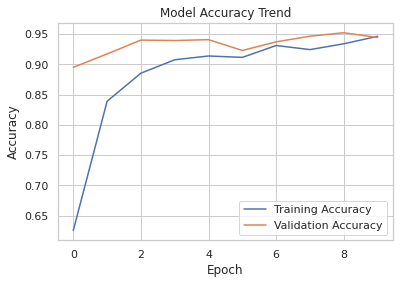

In [116]:
#Plot training and validation accuracy against epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy Trend")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training Accuracy", "Validation Accuracy"], loc="lower right")
plt.show()

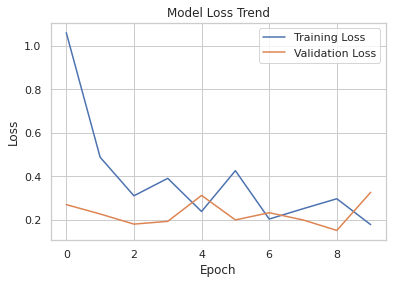

In [117]:
#Plot training and validation loss against epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss Trend")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Training Loss", "Validation Loss"], loc="upper right")
plt.show()

#### Save the model

In [118]:
model.save('VGG16-CatDog-model.h5')